In [1]:
import enspp.bma as bma
import enspp.vis as vis

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from wrfpywind import data_preprocess as pp
import xarray as xr

In [2]:
# Read in the observational data
obs = pp.fmt_buoy_wspd(
                       data_path='/share/mzhang/jas983/wrf_data/oshwind/wrfpywind/wrfpywind/data/nyserda_buoy/', 
                       south_dates_str='20190904_20210207', north_dates_str='20190812_20210207', 
                       heights=[20, 40, 60, 80, 100, 120, 140, 160, 180, 200],
                       start_date='12-01-2019', end_date='12-31-2019')

In [3]:
# Specify the forecast initialization time
t_init = '2019-12-08'

In [4]:
# Fit the BMA model using two historical simulations
fit = bma.read_fmt_fit_bma(t_init, obs, n_days=2, datadir='../data/')

In [5]:
# Read in the ensemble data that you want to correct using BMA
t_init = pd.to_datetime(t_init)
t_end = t_init + pd.DateOffset(days=4)
# Open the xarray Dataset contianing wind speed data for the entire domain 
# note that you must use a `Dataset` object for the `extract_buoy_da` function to work.
ensds = xr.open_dataset(f"../data/ensds_{t_init.strftime('%Y%m%d')}-{t_end.strftime('%d')}.nc")

In [6]:
# Get data only at the buoy locations
ensda = pp.extract_buoy_da(ensds, varname='wspd_wrf', locations=['south', 'north'])

In [7]:
ensda_slice = ensda.sel(location='south', height=100)

In [8]:
# Apply the fit to the ensemble members initialized at t_init
fx = bma.quantile_fx(fit, ensda_slice, obs, quantiles=np.arange(0.01, 1, 0.01))

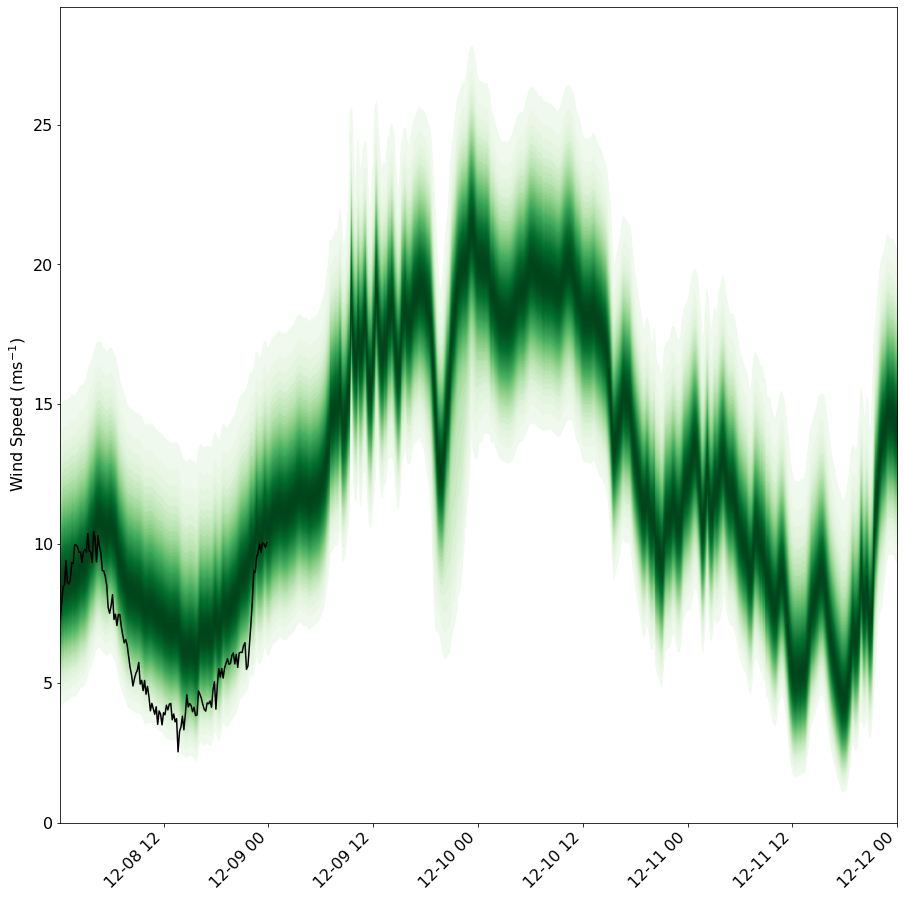

In [9]:
vis.fan(fx=fx, obs=obs.sel(location='south', height=100).squeeze(), p1=None, p2=None, t_issue=t_init, n_days=1, fx_res='10T', title=None, 
    percentile_vals=None, fig_w=15, ylab=True, ylab_txt='Wind Speed (ms$^{-1}$)', 
    show_fig=True, save_fig=False, fig_path='../data/plots/fan_plot.png')